# Universal Pleasantness: Bayesian Modeling

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from copy import copy
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pathlib
import seaborn as sns
from tqdm.auto import tqdm
sns.set(font_scale=1.2)
import univple as up

## Load the data and show the ranking for each odorant

In [ ]:
data = {}
data['raw'], odorants = up.load_data()
groups, group_ids = up.get_groups(data['raw'])
data['raw'].head()  # First 5 rows

## For modeling purposes, switch this to the odor index for rank 1, for rank 2, etc. for each subject

In [ ]:
data['ranked'], odorants = up.load_data(by='ranks')
groups, group_ids = up.get_groups(data['ranked'])
data['ranked'].head()  # First 5 rows

In [11]:
# Reset subject indices for Maniq to be ascending integers from 1 to make modeling easier
z = data['ranked'].reset_index()
n_maniq = (z['Group']=='Maniq').sum()
z.loc[z['Group']=='Maniq', 'Participant'] = range(1, n_maniq+1)
data['ranked'] = z.set_index(['Group', 'Participant']).sort_index()

## A Bayesian Model for Conducting the Same Analysis

In [12]:
# Compile the model, written in Stan (a probabilistic programming language for fitting Bayesian models)
model = up.load_or_compile_stan_model('univple')

In [19]:
# Create shuffles to be modeled as well.
shuffles = ['odors-within-culture', 'individuals', 'odors']
for shuffle in shuffles:
    data['shuffle-%s' % shuffle] = up.shuffle_data(data['ranked'], groups, shuffle)

In [ ]:
# Fit the model to the real data and to the shuffled data
# This will take many hours (or days) if you have no already sampled from these models
# It will take a few minutes if you are just loading the samples
samples = {}
for shuffle in tqdm(['ranked'] + ['shuffle-%s' % shuffle for shuffle in shuffles]):
    %time samples[shuffle] = up.load_or_sample(model, data[shuffle], shuffle)

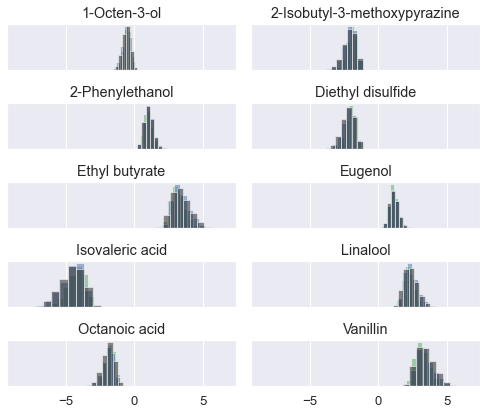

In [29]:
# Check if independent sampling chains (runs with different random starting points) agree on global odorant valences
# If each odorant produces 4 almost perfectly overlapping histograms,
# then the fit went well
up.plot_global_agreement(samples['ranked'], odorants)

## Model Consistency Check: Estimated valences and observed ranks are almost perfectly anti-correlated at the individual level (i.e. a high valence is a low (e.g. 1) rank.

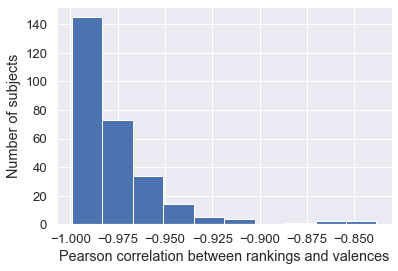

In [37]:
# Distribution of individual-level Pearson Correlation between observed rankings
# and estimated latent valences.  Should be close to -1
# (since lower ranking is more pleasant, but higher rating is more pleasant).
# Differs from exactly -1 due to a) the switch between a cardinal and ordinal measure
# and b) the denoising applied by the model
up.ranks_vs_values(samples['ranked'], groups)

## Show how the group mean valences for each odorant compare.  Order by global mean valence.

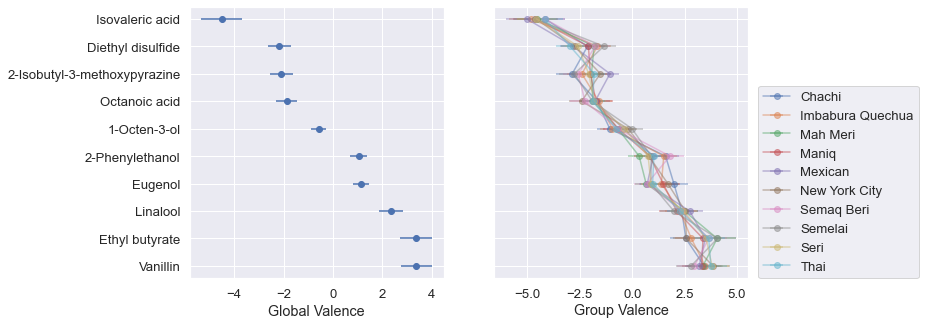

In [39]:
up.plot_global_means(groups, odorants, samples['ranked'])

## Estimate contributions of each factor using the Bayesian model.

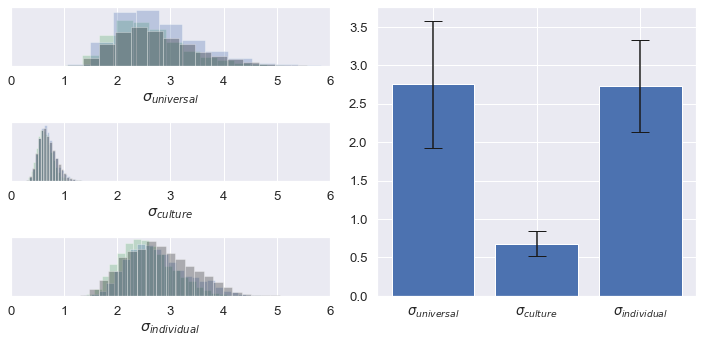

In [41]:
up.plot_sigmas(samples['ranked'], groups)

## Verify that when the model is applied to the shuffled ranks, the contribution of universal valence disappears.  This is a negative control.

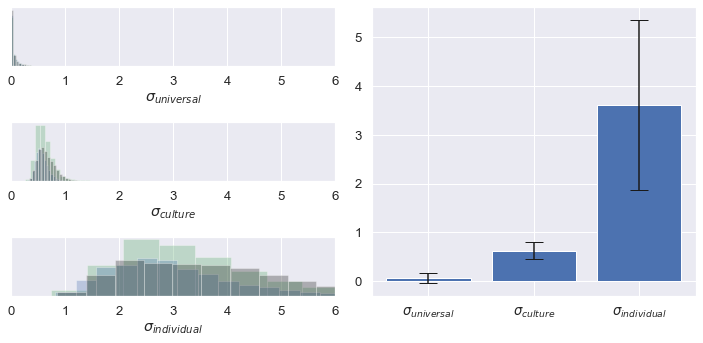

In [42]:
up.plot_sigmas(samples['shuffle-odors-within-culture'], groups)

## Valences are very highly correlated across groups (different groups ranks things similarly), but odorants are not really correlated with one another (how a group ranks one odorant does not closely predict how it will rank another odorant)

In [ ]:
up.get_means(samples['ranked'], groups, odorants, 'mu_group')

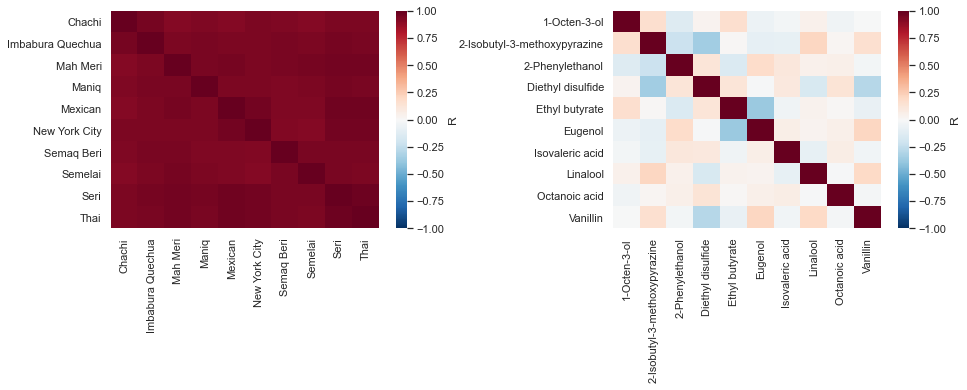

In [44]:
up.corr_heatmaps(samples['ranked'], groups, odorants)

## For the shuffle control, this correlation structure (among groups) disappears

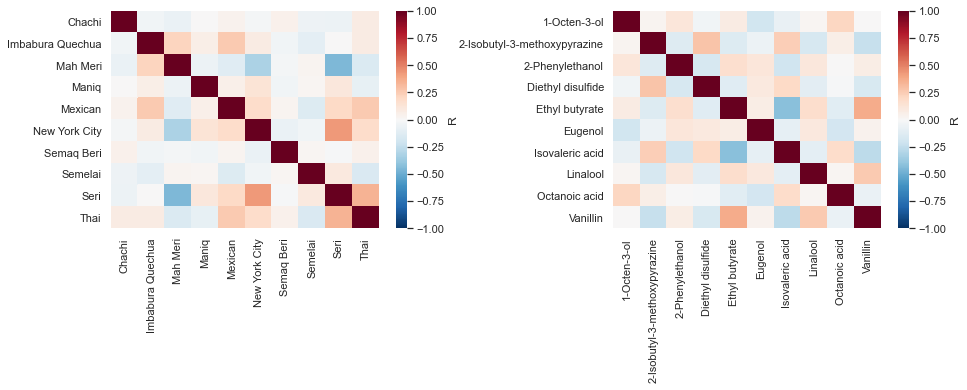

In [47]:
up.corr_heatmaps(samples['shuffle-odors-within-culture'], groups, odorants)

## PCA shows that there is really only one principal component explaining most of the variance in cross-cultural odor ranking.  Operating in the other direction, on odorants, shows a higher-dimensional structure (recapitulates the point in the figures above).

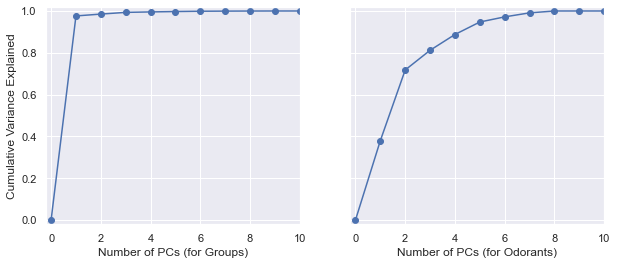

In [48]:
up.plot_var_explained(samples['ranked'], groups, odorants)

## The model estimates the intra-group standard deviations

In [50]:
# Individual variability within a group
intragroup_std = pd.Series([samples['ranked']['sigma_ind[%d]' % x].mean() for x in range(1, len(groups)+1)], index=groups)
intragroup_std.sort_values().to_frame(name='Standard Deviation across Individuals').round(1)

,Standard Deviation across Individuals
Mexican,1.7
Thai,1.7
Seri,2.0
Mah Meri,2.4
Semelai,2.6
New York City,2.8
Imbabura Quechua,3.5
Chachi,3.6
Semaq Beri,3.9
Maniq,12.5


## We can examine this more closely for each group, looking at the correlation in estimated odorant valences between individuals.  This shows that the Maniq are ranking in a way which is indistinguishable from random (red dashed line, KS-test p-value shown)

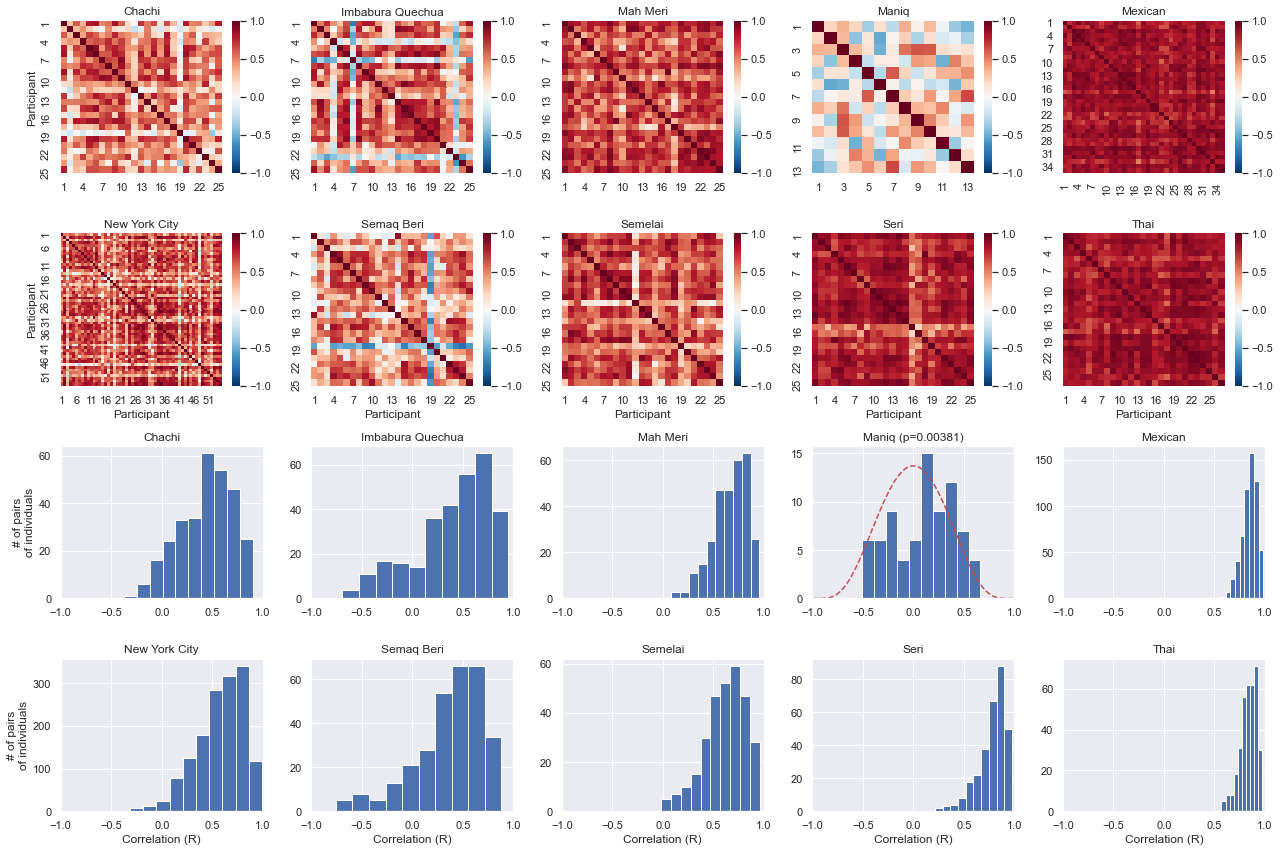

In [53]:
up.plot_ind_corrs(data['ranked'], samples['ranked'], groups, odorants)

## We can look at the groups in a reduced dimension using PCA (big dots are group means, little dots are individuals; many individuals are far away from the mean, illustrating that individual variability (and noise) is large compared to the differences between groups.

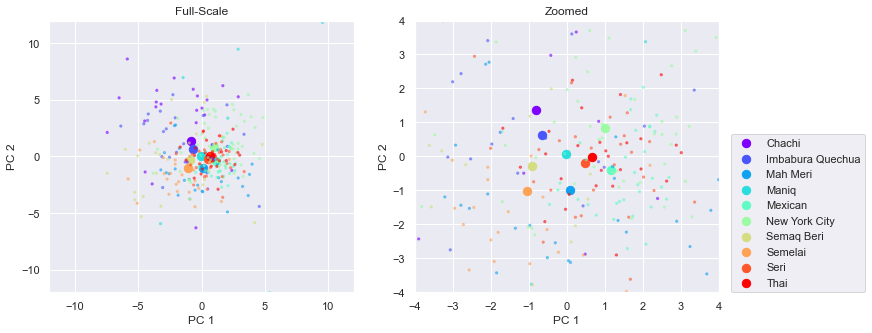

In [52]:
up.plot_all_individuals(samples['ranked'], groups, group_ids, odorants)

## We can then partition the groups into supergroups and ask if these supergroups explain the observed group structure

In [57]:
supergroups = {'subsistence': {'Industrial': ['New York City', 'Thai', 'Mexican'],
                               'Agricultural': ['Semelai', 'Mah Meri', "Chachi", 'Imbabura Quechua'],
                               'Hunter-gatherer': ['Maniq', 'Semaq Beri', 'Seri']},
               'geography': {'North America': ['New York City', 'Seri', 'Mexican'],
                             'South America': ["Chachi", 'Imbabura Quechua'],
                              'Asia': ['Semelai', 'Mah Meri', 'Maniq', 'Semaq Beri', 'Thai']}}

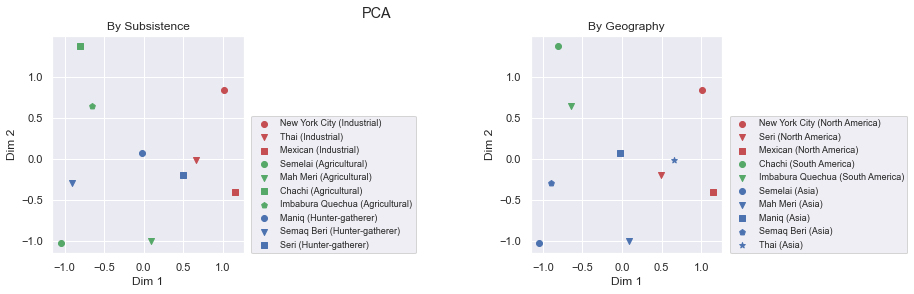

In [58]:
# Plot using PCA as above
up.plot_supergroups(samples['ranked'], groups, odorants, supergroups, method='PCA')

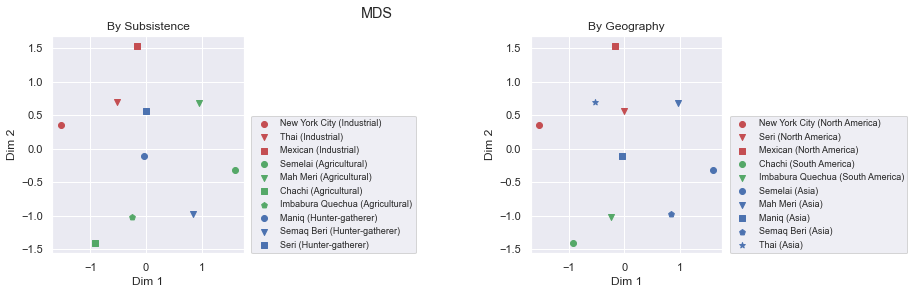

In [59]:
# Plot using Multidimensional Scaling, another dimensionality reduction strategy
up.plot_supergroups(samples['ranked'], groups, odorants, supergroups, method='MDS')

## We next ask whether certain supergroups summarize the group structure.  We compare these groups to random group assignments of the same size to get p-values

In [60]:
supergroup_stats = up.get_supergroup_stats(samples['ranked'], groups, odorants, supergroups)
supergroup_stats.to_frame(name='p')

,p
subsistence,0.1872
geography,0.0032
